In [ ]:
!pip install shap

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
import os
import shap
import time
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from modeling import FoldSet, GridSearch_ML, MLTest
from rnn_modeling import Make_DataSet
from correlation import Correlation
from visualization import Result_pred, Plot_Result, Monthly_plot, TimeBar

# Load data

In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/SolarPower/Jjdata.csv')
print(df.shape)
df

(7769, 14)


,Date,Area,Time,Photovoltaics,PM10,Temperature,Wind velocity,Wind direction,Humidity,Sea-level pressure,Solar radiation,Cloudy,Visibility,Month
0,2018-08-01,경남 진주시,6,0.019,24.0,22.7,0.0,0.0,88.0,1004.2,0.01,3.0,1962.0,8
1,2018-08-01,경남 진주시,7,0.086,31.0,26.2,0.2,0.0,77.0,1004.1,0.38,0.0,1976.0,8
2,2018-08-01,경남 진주시,8,0.160,17.0,27.5,1.0,290.0,68.0,1004.0,1.03,0.0,2000.0,8
3,2018-08-01,경남 진주시,9,0.191,18.0,29.9,2.1,20.0,56.0,1004.0,1.78,2.0,2000.0,8
4,2018-08-01,경남 진주시,10,0.212,23.0,32.2,1.5,50.0,46.0,1003.8,2.41,1.0,2000.0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7764,2020-09-16,경남 진주시,17,18.000,33.0,22.8,0.8,140.0,86.0,1009.0,0.53,10.0,1988.0,9
7765,2020-09-16,경남 진주시,18,2.000,36.0,22.7,1.0,110.0,89.0,1008.4,0.25,5.0,1738.0,9
7766,2020-09-17,경남 진주시,7,9.000,31.0,21.0,0.5,340.0,97.0,1011.3,0.01,10.0,631.0,9
7767,2020-09-17,경남 진주시,8,13.000,29.0,20.8,0.5,20.0,96.0,1011.6,0.06,10.0,916.0,9


In [ ]:
df['Area'].unique()

array(['경남 진주시'], dtype=object)

# Create Deviation Variable

In [ ]:
cols = [x for x in df.columns if x not in ['Date','Area','Month','Time']]
cols

['Photovoltaics',
 'PM10',
 'Temperature',
 'Wind velocity',
 'Wind direction',
 'Humidity',
 'Sea-level pressure',
 'Solar radiation',
 'Cloudy',
 'Visibility']

In [ ]:
testmn, x_train, y_train, x_test, y_test = Make_DataSet(df, 'ML', dev = True)

Train-set:  dev_PM10, dev_Temperature, dev_Wind velocity, dev_Wind direction, dev_Humidity, dev_Sea-level pressure, dev_Solar radiation, dev_Cloudy, dev_Visibility Index(['dev_Photovoltaics'], dtype='object') 
Test-set :  dev_PM10, dev_Temperature, dev_Wind velocity, dev_Wind direction, dev_Humidity, dev_Sea-level pressure, dev_Solar radiation, dev_Cloudy, dev_Visibility Index(['Photovoltaics'], dtype='object')
train: (5256, 9), (5256, 1) test: (2513, 9), (2513, 1)



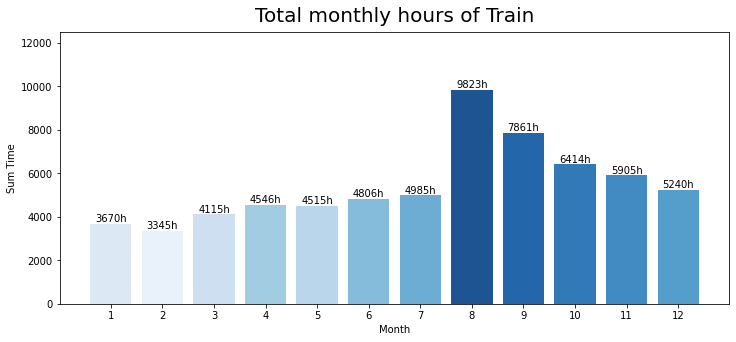

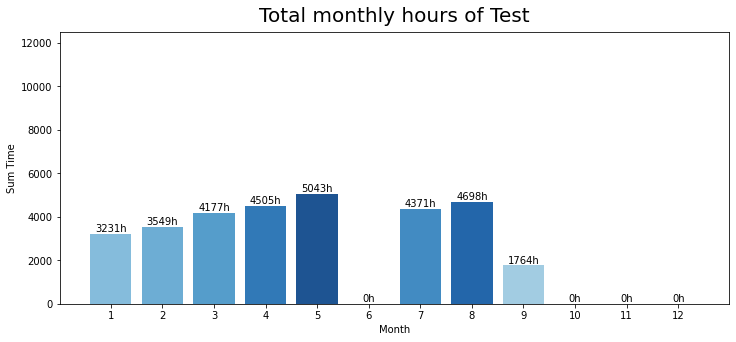

In [ ]:
TimeBar(df.loc[:5256-1], '경남 진주시', 'Train', [0,12500])
TimeBar(df.loc[5256:], '경남 진주시', 'Test', [0,12500])

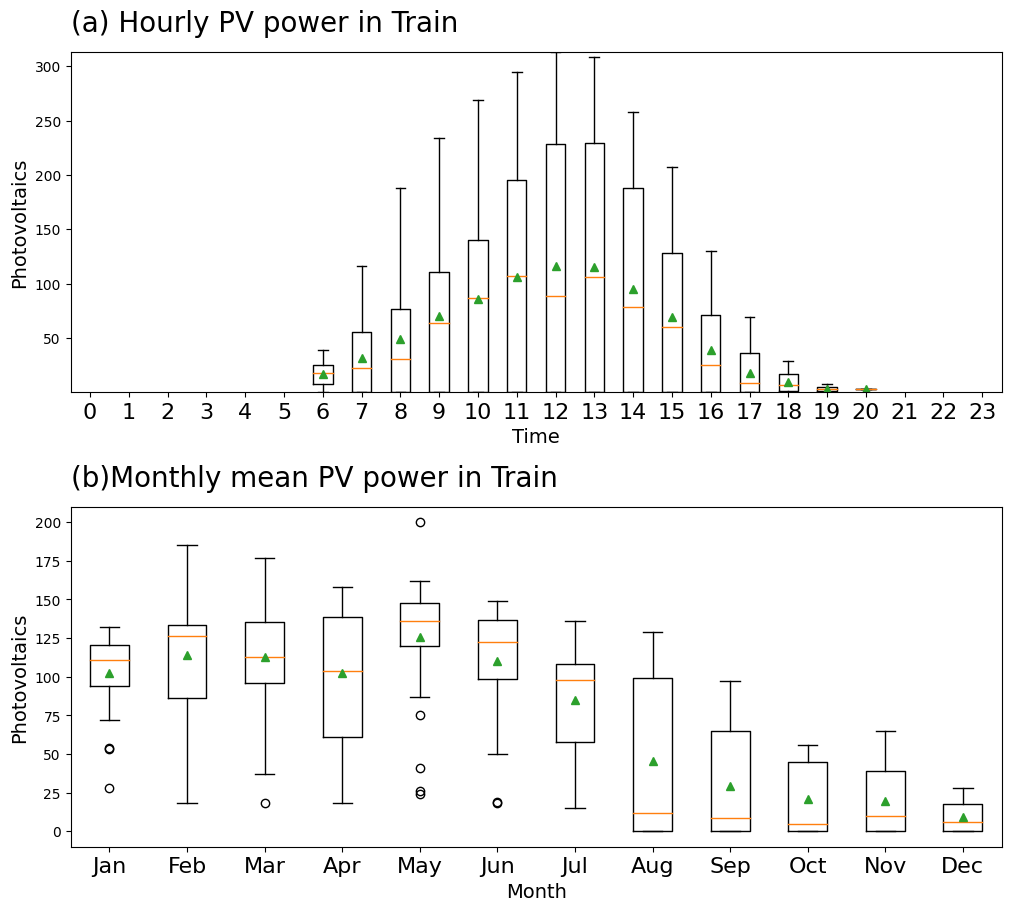

In [ ]:
Monthly_plot(df.loc[:5256-1], 'Photovoltaics', 'Train')

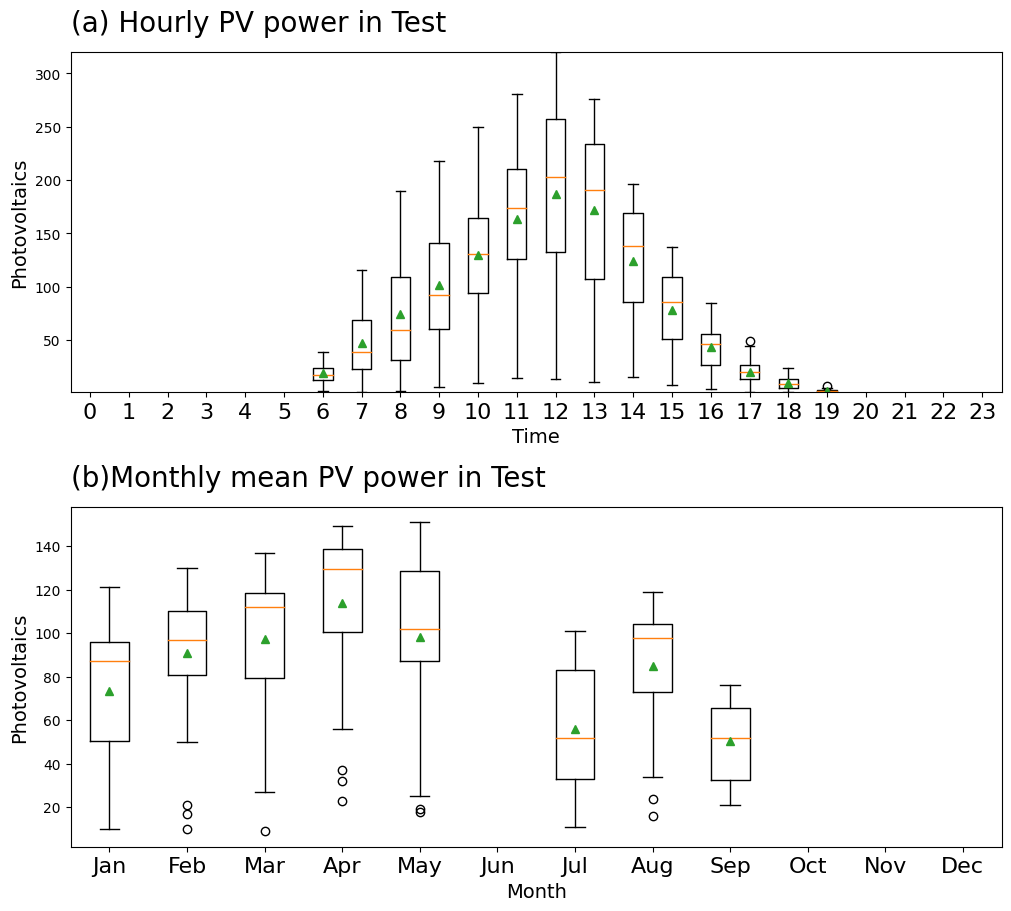

In [ ]:
Monthly_plot(df.loc[5256:], 'Photovoltaics', 'Test')

In [ ]:
train_Jj = pd.concat([x_train, y_train], axis=1)
train_Jj

,dev_PM10,dev_Temperature,dev_Wind velocity,dev_Wind direction,dev_Humidity,dev_Sea-level pressure,dev_Solar radiation,dev_Cloudy,dev_Visibility,dev_Photovoltaics
0,-3.448276,-0.329310,-0.458621,-46.896552,-1.844828,-3.489655,0.008103,-2.224138,759.293103,-7.643224
1,3.150000,2.071667,-0.360000,-50.500000,-9.533333,-3.978333,0.208000,-5.216667,688.966667,-23.473683
2,-10.983871,1.866129,0.138710,149.838710,-12.419355,-4.270968,0.433871,-5.629032,518.903226,-45.389903
3,-10.451613,2.966129,0.825806,-150.161290,-18.677419,-4.241935,0.659355,-3.822581,436.274194,-61.853258
4,-6.295082,4.018033,0.114754,-136.229508,-23.065574,-4.516393,0.833934,-5.163934,401.721311,-68.236836
...,...,...,...,...,...,...,...,...,...,...
5251,-0.734694,1.993878,-1.230612,-179.795918,37.163265,-3.081633,0.043469,3.734694,-75.387755,28.197429
5252,9.500000,2.920000,-1.082000,-188.600000,41.800000,-3.912000,-0.086600,-2.060000,-711.320000,0.038800
5253,-21.629032,-1.770968,2.961290,252.580645,-36.258065,5.658065,-0.009839,-4.435484,802.483871,8.618274
5254,-22.216667,-5.993333,0.733333,181.500000,-17.883333,7.430000,0.419333,-4.533333,268.700000,8.922700


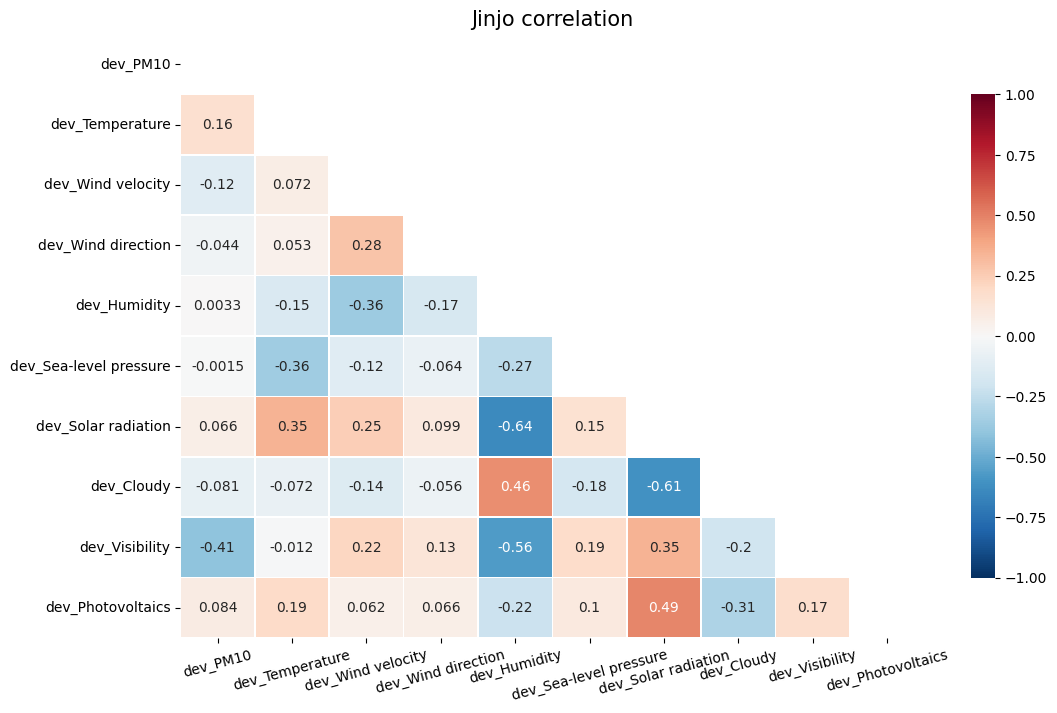

In [ ]:
c = Correlation(train_Jj, train_Jj.columns, 'Jinjo')

# Fine-tuning the model

In [ ]:
params = {}

In [ ]:
params = GridSearch_ML(df, cols, params, dev=True)
params = GridSearch_ML(df, cols, params)

In [ ]:
for k,v in params.items():
  print(k,v)

dev_MLP {'activation': 'identity', 'hidden_layer_sizes': (200,), 'learning_rate': 'invscaling', 'max_iter': 4000, 'solver': 'adam'}
dev_LGBM {'boosting': 'dart', 'learning_rate': 0.001, 'max_depth': 1, 'metric': 'mse', 'num_leaves': 10, 'objective': 'regression'}
ori_MLP {'activation': 'logistic', 'hidden_layer_sizes': (400,), 'learning_rate': 'constant', 'max_iter': 2000, 'solver': 'adam'}
ori_LGBM {'boosting': 'dart', 'learning_rate': 0.001, 'max_depth': -1, 'metric': 'mse', 'num_leaves': 25, 'objective': 'regression'}


# Model Learning

## LR 
(LinearRegression)

In [ ]:
# score점수 저장
score = {}
# shap plot을 위한 값 저장
Shap_dic = {}

In [ ]:
pred_LR = MLTest(df, 'LR', params, score, Shap_dic, dev=True)

Train-set:  dev_PM10, dev_Temperature, dev_Wind velocity, dev_Wind direction, dev_Humidity, dev_Sea-level pressure, dev_Solar radiation, dev_Cloudy, dev_Visibility Index(['dev_Photovoltaics'], dtype='object') 
Test-set :  dev_PM10, dev_Temperature, dev_Wind velocity, dev_Wind direction, dev_Humidity, dev_Sea-level pressure, dev_Solar radiation, dev_Cloudy, dev_Visibility Index(['Photovoltaics'], dtype='object')
train: (5256, 9), (5256, 1) test: (2513, 9), (2513, 1)

train: (876, 9), (876, 1) valid: (876, 9), (876, 1)

train: (1752, 9), (1752, 1) valid: (876, 9), (876, 1)

train: (2628, 9), (2628, 1) valid: (876, 9), (876, 1)

train: (3504, 9), (3504, 1) valid: (876, 9), (876, 1)

train: (4380, 9), (4380, 1) valid: (876, 9), (876, 1)

LinearRegression()


In [ ]:
ignore = MLTest(df, 'LR', params, score, Shap_dic)

Train-set:  PM10, Temperature, Wind velocity, Wind direction, Humidity, Sea-level pressure, Solar radiation, Cloudy, Visibility Index(['Photovoltaics'], dtype='object') 
Test-set :  PM10, Temperature, Wind velocity, Wind direction, Humidity, Sea-level pressure, Solar radiation, Cloudy, Visibility Index(['Photovoltaics'], dtype='object')
train: (5256, 9), (5256, 1) test: (2513, 9), (2513, 1)

train: (876, 9), (876, 1) valid: (876, 9), (876, 1)

train: (1752, 9), (1752, 1) valid: (876, 9), (876, 1)

train: (2628, 9), (2628, 1) valid: (876, 9), (876, 1)

train: (3504, 9), (3504, 1) valid: (876, 9), (876, 1)

train: (4380, 9), (4380, 1) valid: (876, 9), (876, 1)

LinearRegression()


## MLP 
(MLPRegressor)

In [ ]:
pred_MLP = MLTest(df, 'MLP', params, score, Shap_dic, dev=True)

Train-set:  dev_PM10, dev_Temperature, dev_Wind velocity, dev_Wind direction, dev_Humidity, dev_Sea-level pressure, dev_Solar radiation, dev_Cloudy, dev_Visibility Index(['dev_Photovoltaics'], dtype='object') 
Test-set :  dev_PM10, dev_Temperature, dev_Wind velocity, dev_Wind direction, dev_Humidity, dev_Sea-level pressure, dev_Solar radiation, dev_Cloudy, dev_Visibility Index(['Photovoltaics'], dtype='object')
train: (5256, 9), (5256, 1) test: (2513, 9), (2513, 1)

train: (876, 9), (876, 1) valid: (876, 9), (876, 1)

train: (1752, 9), (1752, 1) valid: (876, 9), (876, 1)

train: (2628, 9), (2628, 1) valid: (876, 9), (876, 1)

train: (3504, 9), (3504, 1) valid: (876, 9), (876, 1)

train: (4380, 9), (4380, 1) valid: (876, 9), (876, 1)

MLPRegressor(activation='identity', hidden_layer_sizes=(200,),
             learning_rate='invscaling', max_iter=4000)


In [ ]:
ignore = MLTest(df, 'MLP', params, score, Shap_dic)

Train-set:  PM10, Temperature, Wind velocity, Wind direction, Humidity, Sea-level pressure, Solar radiation, Cloudy, Visibility Index(['Photovoltaics'], dtype='object') 
Test-set :  PM10, Temperature, Wind velocity, Wind direction, Humidity, Sea-level pressure, Solar radiation, Cloudy, Visibility Index(['Photovoltaics'], dtype='object')
train: (5256, 9), (5256, 1) test: (2513, 9), (2513, 1)

train: (876, 9), (876, 1) valid: (876, 9), (876, 1)

train: (1752, 9), (1752, 1) valid: (876, 9), (876, 1)

train: (2628, 9), (2628, 1) valid: (876, 9), (876, 1)

train: (3504, 9), (3504, 1) valid: (876, 9), (876, 1)

train: (4380, 9), (4380, 1) valid: (876, 9), (876, 1)

MLPRegressor(activation='logistic', hidden_layer_sizes=(400,), max_iter=2000)


## LGBM
 (LGBMRegressor)

In [ ]:
pred_LGBM = MLTest(df, 'LGBM', params, score, Shap_dic, dev=True)

Train-set:  dev_PM10, dev_Temperature, dev_Wind velocity, dev_Wind direction, dev_Humidity, dev_Sea-level pressure, dev_Solar radiation, dev_Cloudy, dev_Visibility Index(['dev_Photovoltaics'], dtype='object') 
Test-set :  dev_PM10, dev_Temperature, dev_Wind velocity, dev_Wind direction, dev_Humidity, dev_Sea-level pressure, dev_Solar radiation, dev_Cloudy, dev_Visibility Index(['Photovoltaics'], dtype='object')
train: (5256, 9), (5256, 1) test: (2513, 9), (2513, 1)

train: (876, 9), (876, 1) valid: (876, 9), (876, 1)

train: (1752, 9), (1752, 1) valid: (876, 9), (876, 1)

train: (2628, 9), (2628, 1) valid: (876, 9), (876, 1)

train: (3504, 9), (3504, 1) valid: (876, 9), (876, 1)

train: (4380, 9), (4380, 1) valid: (876, 9), (876, 1)



In [ ]:
ignore = MLTest(df, 'LGBM', params, score, Shap_dic)

Train-set:  PM10, Temperature, Wind velocity, Wind direction, Humidity, Sea-level pressure, Solar radiation, Cloudy, Visibility Index(['Photovoltaics'], dtype='object') 
Test-set :  PM10, Temperature, Wind velocity, Wind direction, Humidity, Sea-level pressure, Solar radiation, Cloudy, Visibility Index(['Photovoltaics'], dtype='object')
train: (5256, 9), (5256, 1) test: (2513, 9), (2513, 1)

train: (876, 9), (876, 1) valid: (876, 9), (876, 1)

train: (1752, 9), (1752, 1) valid: (876, 9), (876, 1)

train: (2628, 9), (2628, 1) valid: (876, 9), (876, 1)

train: (3504, 9), (3504, 1) valid: (876, 9), (876, 1)

train: (4380, 9), (4380, 1) valid: (876, 9), (876, 1)



# Score

In [ ]:
score

{'R2_dev_LR': 0.6832905885401217,
 'RMSE_dev_LR': 42.67189165201663,
 'R2_LR': 0.5397831144085171,
 'RMSE_LR': 51.43901995504766,
 'R2_dev_MLP': 0.6726457844507725,
 'RMSE_dev_MLP': 43.38307983191513,
 'R2_MLP': 0.5772816628946689,
 'RMSE_MLP': 49.29886886769597,
 'R2_dev_LGBM': 0.5297787490862853,
 'RMSE_dev_LGBM': 51.995114302283596,
 'R2_LGBM': -0.41230545513976646,
 'RMSE_LGBM': 90.11056843765209}

In [ ]:
with open('/content/gdrive/MyDrive/SolarPower/Jinjo_score.txt','w',encoding='UTF-8') as f:
  for key, values in score.items():
    f.write(f'{key}:{values}\n')

# Shap plot

In [ ]:
# 모델 학습 후 shap 생성 함수
def ShapPlot(model, x_train, model_name):
  shap.initjs()
  explainer = shap.Explainer(model.predict, x_train) 
  shap_values = explainer(x_train)

  shap.summary_plot(shap_values, x_train, plot_size=0.3, plot_type='bar', show=False)
  plt.title(f"{model_name} Shap barplot", fontsize=15, pad=10)
  plt.show()
  shap.summary_plot(shap_values, x_train, plot_size=0.4, show=False)
  plt.title(f"{model_name} Shap plot", fontsize=15, pad=10)
  plt.show()

Exact explainer: 5257it [01:37, 50.28it/s]


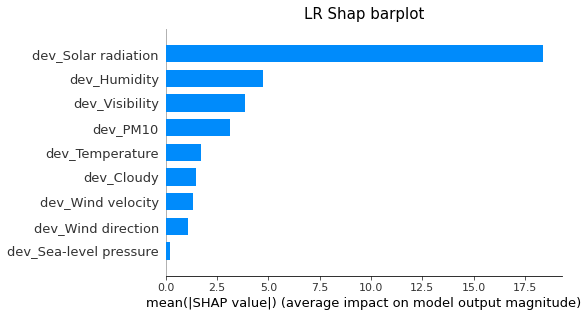

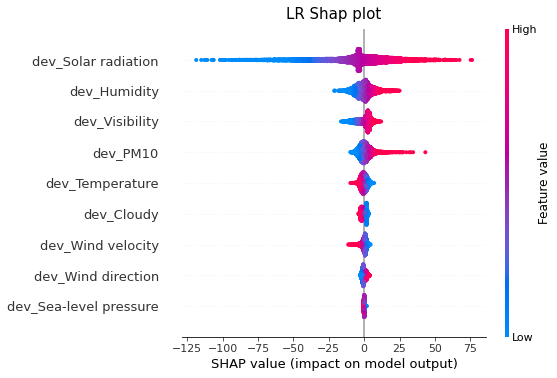

In [ ]:
ShapPlot(**Shap_dic['dev_LR'])

Exact explainer: 5257it [07:10, 11.90it/s]


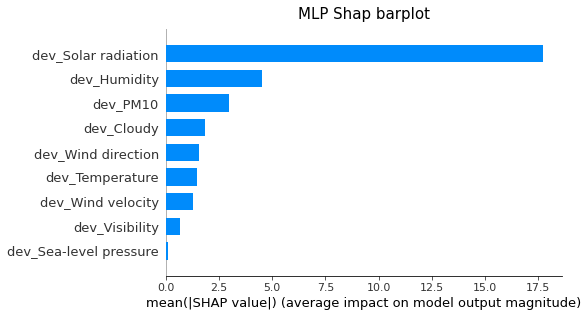

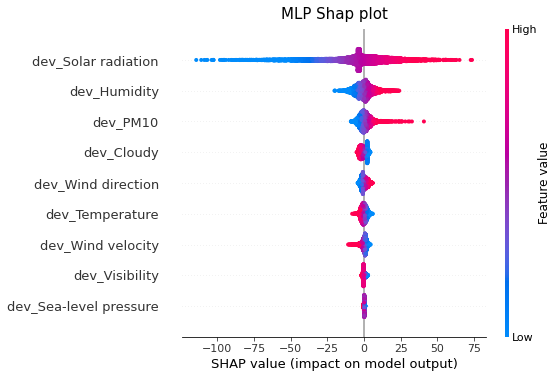

In [ ]:
ShapPlot(**Shap_dic['dev_MLP'])

Exact explainer: 5257it [07:58, 10.75it/s]                          


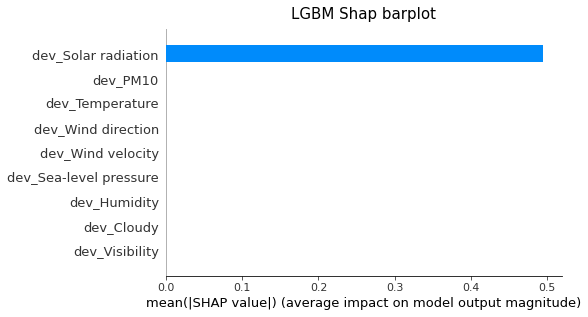

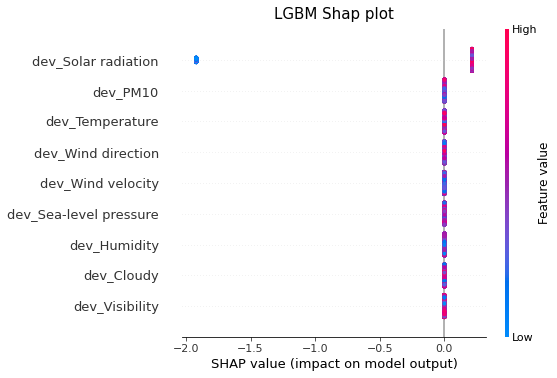

In [ ]:
ShapPlot(**Shap_dic['dev_LGBM'])

# Result

In [ ]:
testmn

,mean_Photovoltaics
0,23.700000
1,57.100000
2,107.300000
3,159.285714
4,216.960000
...,...
2508,8.345754
2509,1.675878
2510,15.402491
2511,31.716368


In [ ]:
data = Result_pred(df, pred_LR, pred_MLP, pred_LGBM, testmn)

In [ ]:
data

,Area,Date,Month,Time,Photovoltaics,LR_Pred,MLP_Pred,LGBM_Pred,train_mean
0,경남 진주시,2020-01-01,1,8,23.0,22.746400,11.245287,24.045840,23.700000
1,경남 진주시,2020-01-01,1,9,64.0,62.105613,52.413365,57.445840,57.100000
2,경남 진주시,2020-01-01,1,10,122.0,111.413720,104.657526,107.645840,107.300000
3,경남 진주시,2020-01-01,1,11,169.0,158.724391,153.724722,159.631554,159.285714
4,경남 진주시,2020-01-01,1,12,215.0,226.251647,222.641939,217.305840,216.960000
...,...,...,...,...,...,...,...,...,...
2508,경남 진주시,2020-09-16,9,17,18.0,11.387042,7.465479,8.691594,8.345754
2509,경남 진주시,2020-09-16,9,18,2.0,8.827168,7.472865,2.021718,1.675878
2510,경남 진주시,2020-09-17,9,7,9.0,10.379886,17.059333,15.748331,15.402491
2511,경남 진주시,2020-09-17,9,8,13.0,14.960911,18.600906,32.062208,31.716368


In [ ]:
data.rename(columns={'Photovoltaics' : 'PV'}, inplace=True)

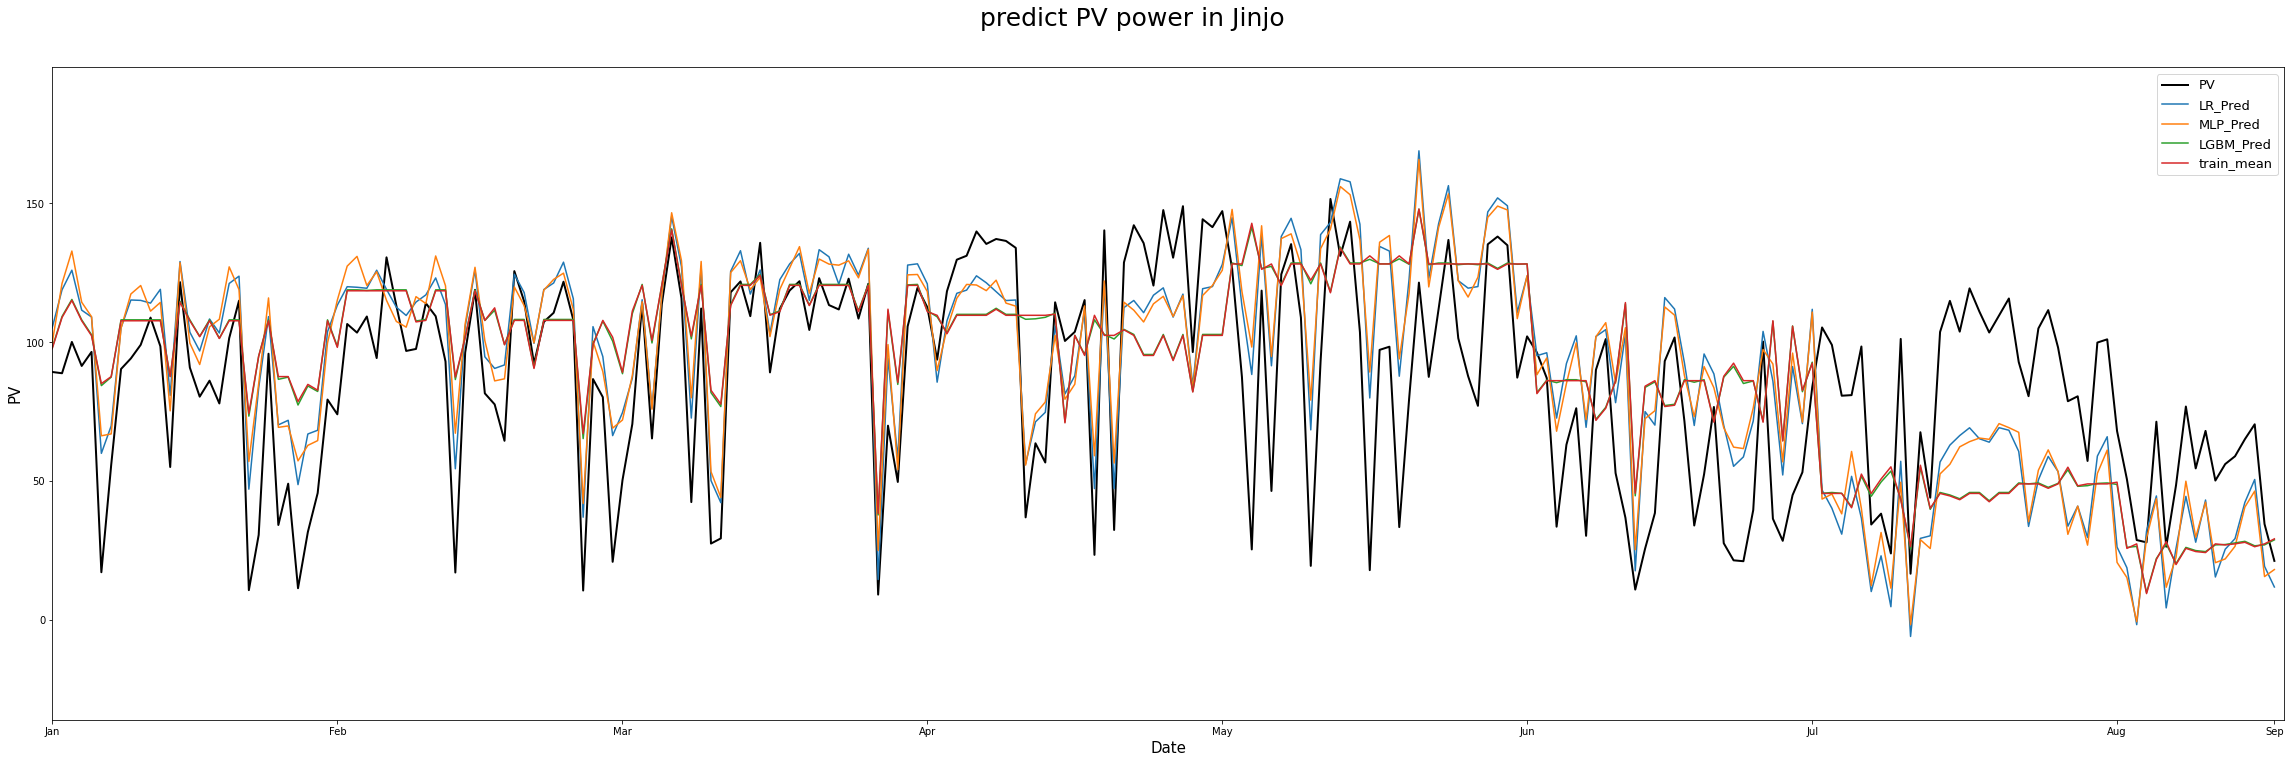

In [ ]:
pred_cols = ['PV', 'LR_Pred', 'MLP_Pred', 'LGBM_Pred' , 'train_mean']
Plot_Result(data, 'Jinjo', pred_cols)